# House Security

In [1]:
# Import Standard Modules
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Import tensor flow Dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

In [3]:
#Avoid OutOfMemory errors by setting GPU memory consumption Growth
gpus=tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus :
    tf.config.experimental.set_memory_grwth(gpu,True)

## Make directories to store data

In [4]:
#setup paths
POS_PATH=os.path.join('data1','positive')
NEG_PATH=os.path.join('data1','negative')
VISIT_PATH=os.path.join('data1','visiter')

In [5]:
#Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(VISIT_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data1\\positive'

## Collecting negative dataset

In [6]:
#https://vis-www.cs.umass.edu/lfw/

In [7]:
#compressed Tar GZ labelled Faces in the wild dataset
!tar -xf lfw.tgz

In [9]:
#Move LFW Images to the following respository/data negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)) :
        EX_PATH=os.path.join('lfw',directory,file)
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

## Collecting Positive and Visiter data

In [10]:
#import uuid library to generate Unique Image Name
#Universally unique identifiers [uuid1(),uuid2()...]
import uuid 

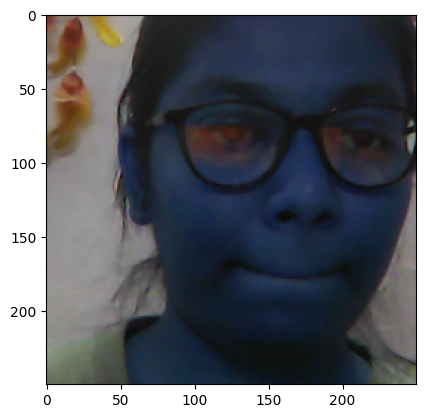

In [11]:
# Esablish a connection to the WebCam
cam=cv2.VideoCapture(0)
while cam.isOpened() :
    ret,frame=cam.read()
    
    #Cut the frame by 250*250px ,it will show captured image
    plt.imshow(frame[190:190+250,200:200+250,:])
    
    #Collect Visiter
    if cv2.waitKey(1) & 0XFF == ord('g'):
        # Ceate the unique file path
        imgname=os.path.join(VISIT_PATH,'{}.jpg'.format(uuid.uuid1()))
        # Write out image anchor
        cv2.imwrite(imgname ,frame)
                                    
    #Collect Positive Images Manually
                                    
                                    
    #To show image back to screen
    cv2.imshow("Image Collection",frame)
    
    #Breaking Gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release WebCam
cam.release()
#Close the image show frame
cv2.destroyAllWindows()

## Load and Process the image

### Get the image directories

In [5]:
visiter=tf.data.Dataset.list_files(VISIT_PATH+'\*.jpg').take(17)
negative=tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(17)
positive=tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(17)

In [6]:
dir_test=visiter.as_numpy_iterator()
print(dir_test.next())

b'data1\\visiter\\71a49b91-d6c8-11ed-9f99-2cd05a85e255.jpg'


### Processing- resize and scale

In [9]:
def preprocess(file_path) :
    
    #Read in image from file path
    byte_img=tf.io.read_file(file_path)
    # Load in the image
    img=tf.io.decode_jpeg(byte_img)
    # preprocessing steps - resizing the image to be 100*100*3 
    img=tf.image.resize(img,(100,100))
    # Scale image to be between 0 and 1
    img=img/255.0
    # returning the image
    return img

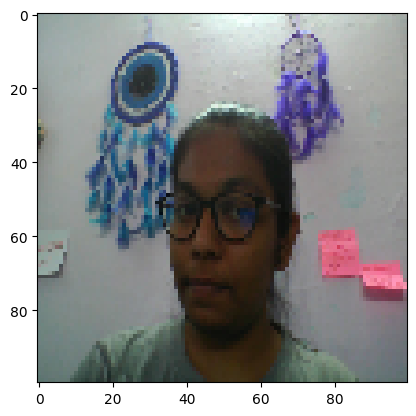

In [10]:
img=preprocess(b'data1\\visiter\\71a49b91-d6c8-11ed-9f99-2cd05a85e255.jpg')
plt.imshow(img)

### Create Labelled Dataset

In [11]:
# (visiter,positive)=>1,1,1,1,1,1,1
# (visiter,negative)=>0,0,0,0,0,0,0

In [12]:
positives=tf.data.Dataset.zip((visiter,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(visiter)))))
negatives=tf.data.Dataset.zip((visiter,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(visiter)))))
data=positives.concatenate(negatives)

In [13]:
sample=data.as_numpy_iterator()
sample.next()

(b'data1\\visiter\\5413f1bf-d6c8-11ed-814c-2cd05a85e255.jpg',
 b'data1\\positive\\Annotation 2023-04-06 232930.jpg',
 1.0)

### Build Train and Test Partition

In [14]:
def preprocess_twin(input_img,validation_img,label) :
    return (preprocess(input_img),preprocess(validation_img),label)

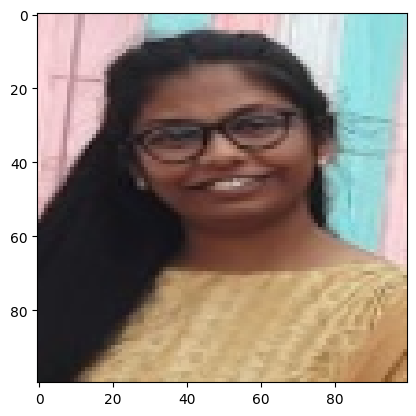

In [15]:
res=preprocess_twin(*(sample.next()))
plt.imshow(res[1])

In [16]:
# Build dataloader pipeline
data=data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [17]:
# Traning partition
train_data=data.take(round(len(data)*.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [18]:
# Testing partition
test_data=data.skip(round(len(data)*.7))
test_data=test_data.take(round(len(data)*.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

## Model Engineering 

### Bulid Embedding Layer

In [19]:
def make_embedding():
    inp=Input(shape=(100,100,3),name='input_image')
    
    # First Block
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)
    
    # Second Block
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)
    
    # Third Block
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)
    
    #Final Embedding Block
    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)
    
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [20]:
embedding=make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Build Distance Layer

In [21]:
# Siamese L1 Distance Class
class L1Dist(Layer) :
    
    # Init method - inheritance
    def __init__(self,**kwargs) :
        super().__init__()
       
    # Magic happens here -similarity calculation
    def call(self,input_embedding,validation_embedding) :
        return tf.math.abs(input_embedding-validation_embedding)

### Make siamese model

In [22]:
def make_siamese_model() :
    
    # Visiter image input in the network
    input_image=Input(name='input_img',shape=(100,100,3))
    
    # Validation image in the network
    validation_image=Input(name='validation_img',shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer=L1Dist()
    siamese_layer._name='distance'
    distances=siamese_layer(embedding(input_image),embedding(validation_image))
    
    # Classicfication layer
    classifier=Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [23]:
siamese_model=make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## Training 

### Setup loss and Optimizer

In [24]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## Establish checkpoints

In [25]:
checkpoint_dir = './train_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### Bulid Train step function

In [26]:
@tf.function
def train_step(batch) :
    
    # Record all of our operations
    with tf.GradientTape() as tape :
        # Get visiter and positive/negative image
        x=batch[:2]
        # Get label
        y=batch[2]
    
        # Forward pass
        yhat=siamese_model(x,training=True)
        # Calculate loss
        loss=binary_cross_loss(y,yhat)
    print(loss)
    
    #Calculate Gradients
    grad=tape.gradient(loss,siamese_model.trainable_variables)
    
    #Calculate updated weight and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    
    # Return loss
    return loss

### Build Training Model

In [27]:
def train(data,EPOCHS) :
    # Loop through epochs
    for epoch in range(1,EPOCHS+1) :
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar=tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx,batch in enumerate(data) :
            # Run trian step here
            train_step(batch)
            progbar.update(idx+1)
            
        # Save checkpoints
        if epoch%10==0 :
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the Model

In [63]:
EPOCHS=10
train(train_data,EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
2/2 [==============================] - 57s 17s/step

 Epoch 2/10
2/2 [==============================] - 52s 17s/step

 Epoch 3/10
2/2 [==============================] - 52s 17s/step

 Epoch 4/10
2/2 [==============================] - 50s 17s/step

 Epoch 5/10
2/2 [==============================] - 53s 18s/step

 Epoch 6/10
2/2 [==============================] - 53s 18s/step

 Epoch 7/10
2/2 [==============================] - 50s 17s/step

 Epoch 8/10
2/2 [==============================] - 52s 17s/step

 Epoch 9/10
2/2 [==============================] - 50s 17s/step

 Epoch 10/10
2/2 [==============================] - 51s 18s/step


## Evaluate Model

In [64]:
# Import Metrics Calculation
from tensorflow.keras.metrics import Precision,Recall

In [65]:
# Get a batch of test data
test_input,test_val,y_true=test_data.as_numpy_iterator().next()

# Make Predictions
y_hat=siamese_model.predict([test_input,test_val])
print(y_hat)

# Post processing the results
[1 if prediction>0.5 else 0 for prediction in y_hat]


1/1 [==============================] - 4s 4s/step
[[0.97491556]
 [0.32860732]
 [0.884442  ]
 [0.9866956 ]
 [0.0403117 ]
 [0.9517449 ]
 [0.62406456]
 [0.13255776]
 [0.90572345]
 [0.07930717]]


[1, 0, 1, 1, 0, 1, 1, 0, 1, 0]

In [66]:
y_true

array([1., 0., 1., 1., 0., 1., 0., 0., 1., 0.], dtype=float32)

In [67]:
# Creating a metric object
m=Recall()

#Calculating the recall value
m.update_state(y_true,y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [68]:
# Creating a metric object
m=Precision()

#Calculating the recall value
m.update_state(y_true,y_hat)

# Return Recall Result
m.result().numpy()

0.8333333

## View Result

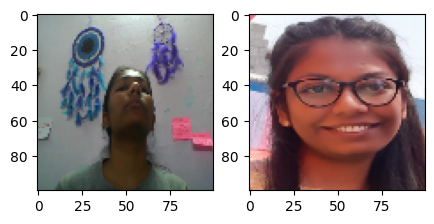

In [69]:
# Set plot size
plt.figure(figsize=(5,8))

# set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Render Cleanly
plt.show()

## Save Model

In [70]:
# save weight
siamese_model.save('Siamesemodel.h5')

In [71]:
L1Dist

__main__.L1Dist

In [72]:
# Reload model
model=tf.keras.models.load_model('Siamesemodel.h5',
                                 custom_objects={'L1Dist' : L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [73]:
# Make prediction with reloaded model
model.predict([test_input,test_val])

1/1 [==============================] - 4s 4s/step


array([[0.97491556],
       [0.32860732],
       [0.884442  ],
       [0.9866956 ],
       [0.0403117 ],
       [0.9517449 ],
       [0.62406456],
       [0.13255776],
       [0.90572345],
       [0.07930717]], dtype=float32)

In [74]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## Real Time Set

### Verification Function

In [75]:
def verify(frame,model,detection_threshold,verification_threshold):
    #Build results array
    results=[]
    for image in os.listdir(os.path.join('application_data1','verification_images')) :
        input_img=preprocess(os.path.join('application_data1','input_images','input_image.jpg'))
        validation_img=preprocess(os.path.join('application_data1','verification_images',image))
        
        #Make Predictions
        result=model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)
   
    # Detection : Matric above which a pradiction is considered positive
    detection=np.sum(np.array(results)>detection_threshold)
    
    # Verification Threshold : Proportion of positive predictions/total positive samples
    verification=detection/len(os.listdir(os.path.join('application_data1','verification_images')))
    verified=verification>verification_threshold
    
    return results,verified
    

## OpenCV Real Time Varification

In [76]:
cam = cv2.VideoCapture(0)
while cam.isOpened() :
    ret,frame=cam.read()
    frame=frame[190:190+250,200:200+250,:]
    
    cv2.imshow('Verification',frame)
    
    
    #Verification Trigger
    if cv2.waitKey(1)&0xFF==ord('v') :
        #Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data1','input_images','input_image.jpg'),frame)
        # Run verification
        results,verified=verify(frame,model, 0.5, 0.5)
        print(verified)
     
    if cv2.waitKey(10)&0xFF==ord('q') :
        break

cam.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 380ms/step
False
1/1 [==============================] - 0s 309ms/step
False
1/1 [==============================] - 1s 591ms/step


1/1 [==============================] - 0s 353ms/step
False
1/1 [==============================] - 0s 451ms/step
False
1/1 [==============================] - 0s 386ms/step
True
1/1 [==============================] - 0s 346ms/step


1/1 [==============================] - 0s 386ms/step
True
